In [1]:
import matplotlib.pyplot as plt
import skimage as sk
from skimage import data, io, filters, color
from skimage.transform import rescale, resize, downscale_local_mean
import pandas as pd
import numpy as np
from math import floor

In [3048]:
img = io.imread('data/1.png')
img = color.rgb2gray(img)
img = rescale(img, 0.08, anti_aliasing=False, anti_aliasing_sigma=7)
img = ((img*2).round()/2).astype(int)

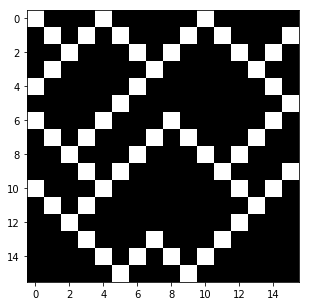

In [3049]:
plt.figure( figsize=(5,5))
plt.imshow(img, cmap='gray',)

In [3865]:
img = io.imread('data/3.png')
img = color.rgb2gray(img)
img = rescale(img, 0.353, anti_aliasing=True, anti_aliasing_sigma=1)
img = ((img).round()).astype(int)

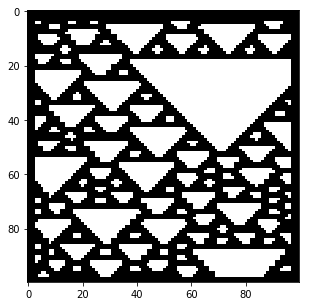

In [3866]:
plt.figure( figsize=(5,5))
plt.imshow(img, cmap='gray',)

In [3867]:
img.shape

(100, 100)

In [3868]:
img = io.imread('data/6.png')
img = color.rgb2gray(img)
img = rescale(img, 1/12, anti_aliasing=False, anti_aliasing_sigma=7)
img = ((img*2).round()/2).astype(int)

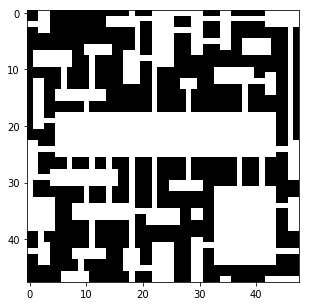

In [3869]:
plt.figure( figsize=(5,5))
plt.imshow(img, cmap='gray',)

TypeError: 'int' object is not iterable

In [2969]:
np.sort(np.array(list(blocks.values())))

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57])

In [2962]:
pd.DataFrame().from_dict(blocks, orient='index').reset_index().reset_index()

,level_0,index,0
0,0,"(0, 0, 1, 0, 0, 1, 1, 1, 1)",0
1,1,"(1, 0, 0, 1, 0, 0, 1, 0, 0)",1
2,2,"(0, 0, 0, 0, 0, 0, 0, 0, 0)",2
3,3,"(0, 0, 0, 0, 0, 1, 0, 0, 1)",3
4,4,"(0, 0, 0, 1, 1, 1, 1, 1, 1)",4
5,5,"(1, 0, 0, 1, 1, 1, 1, 1, 0)",5
6,6,"(0, 1, 1, 1, 1, 1, 0, 1, 1)",6
7,7,"(1, 1, 1, 1, 1, 0, 1, 1, 0)",7
8,8,"(1, 1, 1, 0, 0, 1, 0, 0, 1)",8
9,9,"(1, 0, 0, 1, 1, 1, 1, 0, 0)",9


In [3752]:
img = io.imread('data/pebbles.jpg')
img = color.rgb2gray(img)
img = rescale(img, 1/20, anti_aliasing=True, anti_aliasing_sigma=1.5)
img = (np.round(img*3-0.25)).astype(int)
img = img[:120, :120]

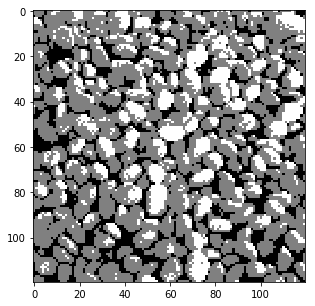

In [3753]:
plt.figure( figsize=(5,5))
plt.imshow(img, cmap='gray',)

In [3394]:
img = io.imread('data/aztec.png')
img = color.rgb2gray(img)
img = rescale(img, 1/6, anti_aliasing=False, anti_aliasing_sigma=1.5)
#img = rescale(img, 1/12, anti_aliasing=False, anti_aliasing_sigma=1.5)

In [3395]:
img

array([[0.95294118, 0.95196078, 0.95294118, ..., 0.95294118, 0.95294118,
        0.95294118],
       [0.99117647, 0.99516873, 0.9981099 , ..., 0.99818059, 0.9981099 ,
        0.99901961],
       [0.9754902 , 0.99411765, 1.        , ..., 1.        , 1.        ,
        0.99019608],
       ...,
       [0.81372549, 0.81176471, 0.81764706, ..., 0.81764706, 0.81764706,
        0.81764706],
       [0.99901961, 0.99901961, 1.        , ..., 1.        , 1.        ,
        0.99019608],
       [0.99243588, 0.99607843, 0.99929863, ..., 1.        , 0.99901961,
        0.99509804]])

In [3396]:
img = (np.round(img)).astype(int)
#img = img[1:109,1:109]

In [3397]:
img

array([[1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       ...,
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1]])

In [3477]:
img.shape

(48, 48)

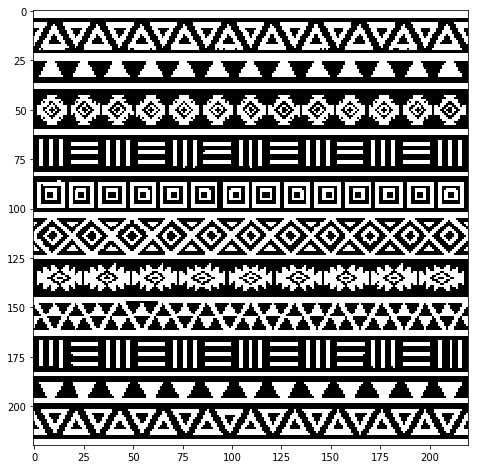

In [3399]:
plt.figure( figsize=(8,8))
plt.imshow(img, cmap='gray',)

In [3171]:
img = io.imread('data/maze.png')
img = color.rgb2gray(img)
img = rescale(img, 1/27, anti_aliasing=False, anti_aliasing_sigma=1.5)
img = (np.round(img)).astype(int)
img = img[:64, :120]

In [3172]:
img.shape

(64, 80)

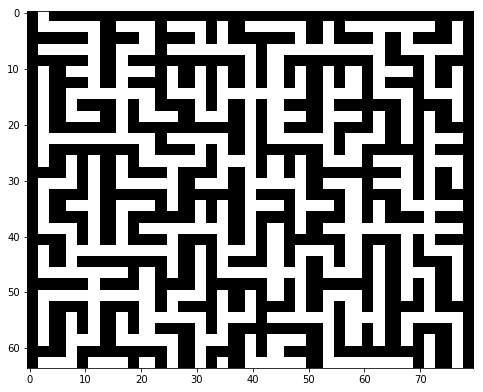

In [3173]:
plt.figure( figsize=(8,8))
plt.imshow(img, cmap='gray',)

Take a 3x3 patch and turn into sequence, treat each entry as categorical variance and compute covariance matrix between each pair

In [3129]:
def preprocess_blocks(img, block_size):
    
#     blocks_count = dict()
    
#     for i in range(0, img.shape[0], kernel_size):
#         for j in range(0, img.shape[1], kernel_size):
#             block = tuple(img[i:i+kernel_size, j:j+kernel_size].flatten())
#             if block not in blocks_dict:
#                 blocks_dict[block] = 1
#                 #blocks_dict[block] = num_blocks
#             else:
#                 blocks_dict[block] += 1
        
#     blocks_count.values
    
#     blocks_id = dict()
#     num_blocks = 0
#     for (block, count) in blocks_count.items():
#         blocks_id[block] 
#         num_blocks+=1

    blocks_id = dict()
    num_blocks = 0
    for i in range(0, img.shape[0], block_size):
        for j in range(0, img.shape[1], block_size):
            block = tuple(img[i:i+block_size, j:j+block_size].flatten())
            if block not in blocks_id:
                blocks_id[block] = num_blocks
                num_blocks+=1
                
    return blocks_id

In [3130]:
img.shape

(48, 48)

In [3133]:
blocks = preprocess_blocks(img, 2)
#blocks_ids = {block_id:block_tup for (block_tup, block_id) in blocks.items()}

In [3134]:
blocks

{(0, 0, 0, 0): 0,
 (1, 1, 1, 1): 1,
 (0, 0, 1, 1): 2,
 (1, 0, 1, 1): 3,
 (1, 1, 0, 0): 4,
 (1, 1, 0, 1): 5,
 (0, 1, 1, 1): 6,
 (1, 0, 1, 0): 7,
 (1, 1, 1, 0): 8,
 (0, 1, 0, 1): 9,
 (0, 0, 1, 0): 10,
 (0, 0, 0, 1): 11,
 (0, 1, 0, 0): 12,
 (1, 0, 0, 0): 13}

In [3135]:
img.shape

(48, 48)

In [3136]:
def convert_img_to_blocks(img, block_size, blocks_dict):
    
    block_img = np.zeros((
        int(img.shape[0]/block_size), 
        int(img.shape[1]/block_size)))
    
    for i in range(0, img.shape[0], block_size):
        for j in range(0, img.shape[1], block_size):
            block = tuple(img[i:i+block_size, j:j+block_size].flatten())
            block_img[
                int(i/block_size),int(j/block_size)] = blocks_dict[block]
                        
    return block_img.astype(int)

def convert_blocks_to_img(block_img, block_size, blocks_dict):
    
    block_ids = {block_id:block_tup for (block_tup, block_id) in blocks.items()}
    
    img = np.zeros((
        int(block_img.shape[0]*block_size), 
        int(block_img.shape[1]*block_size)))
    
    for i in range(block_img.shape[0]):
        for j in range(block_img.shape[1]):
            block_id = block_img[i,j]
            block = block_ids[block_id]
            block = np.array(block).reshape((block_size, block_size))
            img[i*block_size : (i+1)*block_size, 
                j*block_size : (j+1)*block_size] = block
                        
    return img

In [3137]:
convert_blocks_to_img(convert_img_to_blocks(img, 2, blocks), 2, blocks)

/Users/milesturpin/miniconda3/lib/python3.6/site-packages/IPython/core/displayhook.py:271: UserWarning: Output cache limit (currently 1000 entries) hit.
Flushing oldest 200 entries.
  'Flushing oldest {cull_count} entries.'.format(sz=sz, cull_count=cull_count))


array([[0., 0., 1., ..., 1., 1., 1.],
       [0., 0., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 1., 1.]])

In [4]:
def ndim2flat_idx(idx, shape):
    """
    Inverse to np.unravel_index.
    
    E.g. ndim2flat_idx([1,2], (3,3)) = 5
    """
    flat_idx = 0
    place = 1
    for i in range(len(idx))[::-1]:
        if idx[i] >= shape[i]:
            raise ValueError('Index too big for shape!')
        flat_idx += idx[i]*place
        place = place*shape[i]
    return flat_idx

oh wait Im counting if matches self oops

In [3184]:
# num loops = 64*64*50*50 = 10 million

def compute_count_tensor(img, kernel_size, stride):
    """
    Currently kernel size is also stride.
    """
    
    indices = [[i,j] for i in range(kernel_size) for j in range(kernel_size)]
    
    w = img.shape[1]
    h = img.shape[0]
    num_convs_w = floor((w-kernel_size)/stride)+1
    num_convs_h = floor((h-kernel_size)/stride)+1
    
    count_tensor = np.zeros([kernel_size**2, kernel_size**2, 
                             np.max(img)-np.min(img)+1, np.max(img)-np.min(img)+1])
    print(count_tensor.shape)
    for i in range(0, num_convs_h, stride):
        for j in range(0, num_convs_w, stride):
            for idx1 in indices:
                for idx2 in indices:

                    idx = (
                        ndim2flat_idx(idx1, (kernel_size,kernel_size)),
                        ndim2flat_idx(idx2, (kernel_size,kernel_size)),
                        img[i + idx1[0], j + idx1[1]],
                        img[i + idx2[0], j + idx2[1]]
                    )

                    if idx1 != idx2:
                        count_tensor[idx] = count_tensor[idx] + 1
                        
    return count_tensor


def normalize_count_tensor(count_tensor):
    normalized_tensor = count_tensor / np.sum(count_tensor, axis=(2,3), keepdims=True)
    affinity_tensor = np.log(normalized_tensor + 0.0000001)
    affinity_tensor = np.nan_to_num(affinity_tensor, nan=0)
    return affinity_tensor

In [3870]:
orig_img = img

In [3871]:
img = orig_img

In [3872]:
img.shape

(48, 48)

In [3873]:
block_size=3
print(img.shape[0]*img.shape[1]/(block_size**2))
blocks = preprocess_blocks(img, block_size)
img = convert_img_to_blocks(img, block_size, blocks)

256.0


In [3874]:
img.shape

(16, 16)

In [3875]:
np.max(img)

57

In [3877]:
kernel_size = 2
learn_stride= 1
stride = 1
num_colors = np.max(img) - np.min(img) + 1
count_tensor = compute_count_tensor(img, kernel_size=kernel_size, stride=learn_stride)
affinity_tensor = normalize_count_tensor(count_tensor)

(4, 4, 58, 58)


/Users/milesturpin/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in true_divide


In [3878]:
#np.swapaxes(np.swapaxes(count_tensor, 0,2), 1,3).round(2)

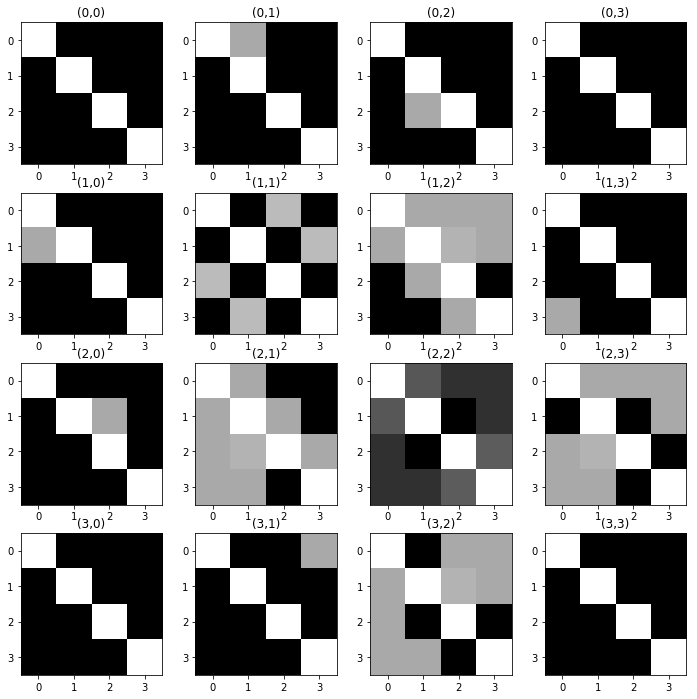

In [3879]:
fig, axes = plt.subplots(4,4, figsize=(12,12))
for i in range(4):
    for j in range(4):
        axes[i,j].imshow(affinity_tensor[:,:,i,j], cmap='gray')
        axes[i,j].set_title(f'({i},{j})')

In [3450]:
def calc_total_log_prob(affinity_tensor, img, kernel_size, stride):
    
    w = img.shape[1]
    h = img.shape[0]
    num_convs_w = floor((w-kernel_size)/stride)+1
    num_convs_h = floor((w-kernel_size)/stride)+1
    
    log_prob = 0
    cnt2 = 0
    for i in stride * np.arange(num_convs_h):
        #print('i', i)
        for j in stride * np.arange(num_convs_w):
            #print('j', j)
            local_prob, cnt = calc_log_prob(affinity_tensor, img, i, j, kernel_size)
            log_prob = log_prob + local_prob
            #print(cnt)
            cnt2 += cnt
                    
    return log_prob, cnt2

def calc_log_prob(affinity_tensor, img, i, j, kernel_size):
    
    indices = [[i,j] for i in range(kernel_size) for j in range(kernel_size)]
    log_prob = 0
    #res = []
    #res2 = []
    cnt = 0
    for pos1 in range(kernel_size**2):
        # plus 1 so that no collisions
        for pos2 in range(pos1+1, kernel_size**2):
            idx1 = indices[pos1]
            idx2 = indices[pos2]
            #print(idx1, idx2)

            idx = (
                pos1, 
                pos2,
                img[i + idx1[0], j + idx1[1]],
                img[i + idx2[0], j + idx2[1]]
            )
            
            if idx1 != idx2:
                #res.append(int(affinity_tensor[idx]))
                #res2.append({(i,j, ndim2flat_idx(idx1, (kernel_size,kernel_size)),
                #   ndim2flat_idx(idx2, (kernel_size,kernel_size))) :int(affinity_tensor[idx])})
                log_prob = log_prob + affinity_tensor[idx]
                cnt+=1
                    
    return log_prob, cnt
#, res, res2

In [2486]:
def construct_filters_idx_dict(shape, kernel_size, stride):
    """
    Creates a dict that gives all the absolute sequence image indexes in each filter
    E.g.
    (0, 2) -> [2, 3, 8, 9 ...]
    
    """
    
    image_idx = np.arange(shape[0]*shape[1]).reshape(shape)
    
    num_convs_h = floor((shape[0]-kernel_size)/stride)+1
    num_convs_w = floor((shape[1]-kernel_size)/stride)+1
    
    total = dict()
    
    log_prob = 0
    cnt2 = 0
    for i in stride * np.arange(num_convs_h):
        for j in stride * np.arange(num_convs_w):
            
            sub_img = image_idx[i:i+kernel_size, j:j+kernel_size].flatten().tolist()
            total[(i,j)] = sub_img
    return total

def invert_dict(d): 
    inverse = dict() 
    for key in d: 
        # Go through the list that is saved in the dict:
        for item in d[key]:
            # Check if in the inverted dict the key exists
            if item not in inverse: 
                # If not create a new list
                inverse[item] = [key] 
            else: 
                inverse[item].append(key) 
    return inverse

def invert_filter2img_dict(filter_idx_to_image_idx, kernel_size, shape): 
    """
    output_dict behavior: 35 -> [(0, 2, 9), (2, 2, 7) … ] 
    """
    
    image_idx_to_filter_idx = dict() 
    for (i,j), img_idxs in filter_idx_to_image_idx.items(): 
        # Go through the list that is saved in the dict:
        for img_idx in img_idxs:
            # Check if in the inverted dict the key exists
            if img_idx not in image_idx_to_filter_idx: 
                # If not create a new list
                # (kernel idx0, kernel idx1, relative position in kernel)
                ker_seq_pos = get_seq_pos(i,j,kernel_size, shape, img_idx)
                image_idx_to_filter_idx[img_idx] = [(i, j, ker_seq_pos)] 
            else: 
                ker_seq_pos = get_seq_pos(i,j,kernel_size, shape, img_idx)
                image_idx_to_filter_idx[img_idx].append((i, j, ker_seq_pos))
    image_idx_to_filter_idx = {
        key:np.array(val) for key, val in image_idx_to_filter_idx.items()
    }
    return image_idx_to_filter_idx

def construct_alternate_img_array(image_idx_to_filter_idx, img, kernel_size, stride):
    """
    Construct another way to index into image values
    (i, j, rel_ker_pos, image value)
    Makes it easy to 
    
    Just need to keep updated similarly to image. There are dependencies here.
    """
    
    arr = np.zeros((
        num_convs(img.shape[0], kernel_size, stride),
        num_convs(img.shape[1], kernel_size, stride),
        kernel_size**2))
    
    for abs_seq_idx, pos_info in image_idx_to_filter_idx.items(): 
        # Go through the list that is saved in the dict:
        for (i, j, rel_pos) in pos_info:
            img_idx = np.unravel_index(abs_seq_idx, img.shape)
            arr[int(i/stride), int(j/stride), rel_pos] = img[img_idx]
    
    return arr

In [2467]:
filter_idx_to_image_idx = construct_filters_idx_dict((3,3), 2, 1)
#image_idx_to_filter_idx = invert_dict(filter_idx_to_image_idx)
image_idx_to_filter_idx = invert_filter2img_dict(filter_idx_to_image_idx, 2, (3,3))
alt_img = construct_alternate_img_array(
    image_idx_to_filter_idx, np.arange(9).reshape((3,3), order='C'), 2, 1)

In [2468]:
alt_img.shape

(2, 2, 4)

In [2469]:
np.arange(9).reshape((3,3))

array([[0, 1, 2],
       [3, 4, 5],
       [6, 7, 8]])

In [2470]:
alt_img

array([[[0., 1., 3., 4.],
        [1., 2., 4., 5.]],

       [[3., 4., 6., 7.],
        [4., 5., 7., 8.]]])

In [2472]:
alt_img[0,0,:]

array([0., 1., 3., 4.])

In [2337]:
num_convs = lambda dim_len, kernel_size, stride: floor((dim_len-kernel_size)/stride)+1

In [2331]:
alt_img[image_idx_to_filter_idx[34], 4]

array([[ 0, 33,  1],
       [ 0, 34,  0]])

In [2336]:
alt_img[:10]

array([[0, 0, 0, 0],
       [0, 0, 1, 0],
       [0, 1, 0, 0],
       [0, 0, 2, 1],
       [1, 0, 0, 1],
       [0, 0, 3, 0],
       [0, 1, 2, 0],
       [1, 0, 1, 0],
       [1, 1, 0, 0],
       [0, 1, 1, 0]])

In [2383]:
alt_img.shape

(13, 13, 81, 4)

In [2388]:
alt_img[0,3,3]

array([ 3,  0, 42,  0])

In [2381]:
image_idx_to_filter_idx[34]

array([[ 0, 27,  7],
       [ 0, 30,  4],
       [ 0, 33,  1]])

In [2385]:
stride

3

In [2387]:
alt_img[
    (image_idx_to_filter_idx[34][:,0]/stride).astype(int),
    (image_idx_to_filter_idx[34][:,1]/stride).astype(int),
    image_idx_to_filter_idx[34][:,2],
    :
]

array([[ 6, 12,  3,  0],
       [ 0, 15,  4,  1],
       [ 0, 15, 57,  1]])

In [2328]:
alt_img.shape

(44100, 4)

In [2318]:
image_idx_to_filter_idx[1000]

array([[ 8, 45,  3],
       [ 8, 46,  2],
       [ 9, 45,  1],
       [ 9, 46,  0]])

In [2303]:
img.shape

(106, 106)

In [749]:
set(image_idx_to_filter_idx[34])

{(0, 0), (0, 2), (2, 0), (2, 2)}

In [794]:
def get_seq_pos(i, j, kernel_size, shape, abs_seq_pos):
    abs_idx = np.unravel_index(abs_seq_pos, shape)
    ker_pos = abs_idx - np.array([i,j])
    seq_pos = ker_pos[0]*kernel_size + ker_pos[1]
    return seq_pos

In [795]:
get_seq_pos(0,2, 4, (16,16), 34)

8

In [3461]:
def calc_total_log_prob(affinity_tensor, img, kernel_size, stride):
    
    w = img.shape[1]
    h = img.shape[0]
    num_convs_w = floor((w-kernel_size)/stride)+1
    num_convs_h = floor((h-kernel_size)/stride)+1
    
    log_prob = 0
    for i in stride * np.arange(num_convs_h):
        for j in stride * np.arange(num_convs_w):
            local_prob = calc_log_prob(affinity_tensor, img, i, j, kernel_size)
            log_prob = log_prob + local_prob
    #print(log_prob)
    return log_prob

def calc_log_prob(affinity_tensor, img, i, j, kernel_size):
    
    # Goes in order across rows e.g. (0,0) (0,1) etc.
    indices = [[i,j] for i in range(kernel_size) for j in range(kernel_size)]
    log_prob = 0
    for pos1 in range(kernel_size**2):
        # plus 1 so that no collisions
        for pos2 in range(pos1+1, kernel_size**2):
            idx1 = indices[pos1]
            idx2 = indices[pos2]
            idx = (pos1, pos2,
                img[i + idx1[0], j + idx1[1]],
                img[i + idx2[0], j + idx2[1]])         
            log_prob = log_prob + affinity_tensor[idx]    
    #print(log_prob)
    return log_prob

## Prob of img

In [3527]:
calc_total_log_prob(affinity_tensor, img, kernel_size, stride)

-168487.18748769775

In [3528]:
calc_total_log_prob(affinity_tensor, np.zeros(img.shape).astype(int), kernel_size, stride)

-109977.14533204271

-315009.91827381356


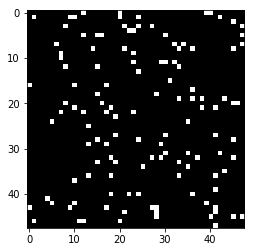

In [1050]:
arr = (np.random.rand(img.shape[0],img.shape[1]) < 0.05).astype(int)       
print(calc_total_log_prob(affinity_tensor, arr, 8,4))
plt.imshow(arr, cmap='gray')

In [2702]:
calc_total_log_prob(
    affinity_tensor, (np.zeros(img.shape)+1).astype(int), kernel_size, stride)

-18732387.029929664

-13276.974854295566


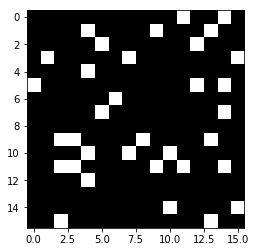

In [767]:
arr = (np.random.rand(16,16) < 0.2).astype(int)
print(calc_total_log_prob(affinity_tensor, arr, 4, 2))
plt.imshow(arr, cmap='gray')

scan across the image, at every location, look at all pairwise combinations of pixels in the window, and add a count to the co-occurence values 

[idx, data] size (3^2 * (width-2)^2, 4)
0, 6, 0, 1
0, 4, 1, 0

or

[pos1, pos2, conv_filter_idx]

-> [pos1, pos2, value1, value2] = count; size (9, 9, 2, 2)

In [158]:
calc_log_prob(affinity_tensor, img, 9, 9, 4)

-171.4119594134845

In [719]:
np.array(filter_idx_to_image_idx[(0,2)])

array([ 2,  3,  4,  5, 18, 19, 20, 21, 34, 35, 36, 37, 50, 51, 52, 53])

In [726]:
np.array([
                img[np.unravel_index(image_idx, img.shape)]
                for image_idx 
                in filter_idx_to_image_idx[(0,2)]])

array([0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0])

In [737]:
np.arange(9).reshape((3,3))[np.arange(3),[0,1,2]]

array([0, 4, 8])

In [736]:
np.arange(9).reshape((3,3))[:,[1,2]]

array([[1, 2],
       [4, 5],
       [7, 8]])

In [2299]:
affinity_tensor[
            :, 
            np.arange(81), 
            1, 
            [
                img[np.unravel_index(image_idx, img.shape)]
                for image_idx 
                in filter_idx_to_image_idx[(0,3)]]].shape

(81, 81)

In [1490]:
affinity_tensor.shape

(64, 64, 2, 2)

In [2254]:
37 % 16

5

In [2255]:
37 // 16

2

In [2319]:
np.repeat(np.array([0,2,1]), 3)

array([0, 0, 0, 2, 2, 2, 1, 1, 1])

In [ ]:
image_idx_to_filter_idx

In [3787]:
alt_img.shape

(13, 13, 81)

In [2974]:
def test():
    abs_seq_pos = 34
    filter_info = image_idx_to_filter_idx[abs_seq_pos]
    print(filter_info)
    num_overlapping_filters = filter_info.shape[0]

    relative_positions = filter_info[:,2]
    rep_relative_positions = np.repeat(
        relative_positions, kernel_size**2)
    rep_arange = np.tile(np.arange(kernel_size**2), num_overlapping_filters)
    
    #print(kernel_img_vals)
    kernel_img_vals = alt_img[
        np.repeat((filter_info[:,0]/stride).astype(int), kernel_size**2),
        np.repeat((filter_info[:,1]/stride).astype(int), kernel_size**2),
        rep_arange].astype(int)

    aff = affinity_tensor[
            rep_relative_positions, 
            rep_arange, 
            # index later to get modded config?
            :, 
            kernel_img_vals
    ]
    
    return aff

test().shape

[[ 0 24 10]
 [ 0 32  2]]


IndexError: index 81 is out of bounds for axis 2 with size 81

In [3057]:


def mcmc_step(affinity_tensor, img, alt_img, beta, kernel_size, stride, sample_prop=1, 
              max_filters=100, step=None, pix_by_pix=False):
    '''Monte Carlo step using Metropolis algorithm '''
    
    # Get the kernel indices that we're calculating energy for
    h=img.shape[0]
    w=img.shape[1]
    num_convs_w = floor((w-kernel_size)/stride)+1
    num_convs_h = floor((h-kernel_size)/stride)+1
    
    image_idx = np.arange(img.shape[0]*img.shape[1]).reshape(img.shape)
    
    if pix_by_pix:
        # Update pixel by pixel in sequence
        abs_seq_pos = step % (h*w)
    else:
        abs_seq_pos = np.random.randint(h*w)
    abs_idx = np.unravel_index(abs_seq_pos, (h, w))

    # Get current config for pos1 and pos2 and propose new config
    # Accept config with some probability
    
    current_config = img[abs_idx]
    modded_img = img.copy()
    proposal_config = np.random.randint(num_colors)
    while proposal_config == current_config:
        proposal_config = np.random.randint(num_colors)
    modded_img[abs_idx] = proposal_config
    
#     print('kernel' , kernel_size,'stride', stride)
#     print('kernel idx:', kernel_idx)
#     print(pos1, pos2, idx1, idx2)
#     print('abs_idx1:', abs_idx1, 'abs_idx2:', abs_idx2)
#     print('current', current_config)
#     print('mod', modded_img[abs_idx1], modded_img[abs_idx2])
    #print('kernel' , kernel_size,'stride', stride)
    #print(abs_seq_pos, abs_idx)
    #print('current', current_config)
    
    # array of shape (num overlapping filters, 3), rows are (0,2,5)
    filter_info = image_idx_to_filter_idx[abs_seq_pos]
    num_overlapping_filters = filter_info.shape[0]
    
    relative_positions = filter_info[:,2]
    rep_relative_positions = np.repeat(
        relative_positions, kernel_size**2)
    rep_arange = np.tile(np.arange(kernel_size**2), num_overlapping_filters)
    
    kernel_img_vals = alt_img[
        np.repeat((filter_info[:,0]/stride).astype(int), kernel_size**2),
        np.repeat((filter_info[:,1]/stride).astype(int), kernel_size**2),
        rep_arange].astype(int)
    
    aff = affinity_tensor[
            rep_relative_positions, 
            rep_arange, 
            # index later to get modded config?
            :, 
            kernel_img_vals
    ]
    
    likelihoods = aff.sum(axis=0)
    log_diff = likelihoods[proposal_config] - likelihoods[current_config]

    # If higher likelihood then keep
    if log_diff >= 0:
        #print('accept!')
        alt_img[
            (filter_info[:,0]/stride).astype(int),
            (filter_info[:,1]/stride).astype(int),
            filter_info[:,2]] = proposal_config
        return modded_img, alt_img, 1, log_diff
    
    # if lower likelihood, accept with some prob
    elif np.random.rand() < np.exp(log_diff*beta):
        #print('accept!')
        alt_img[
            (filter_info[:,0]/stride).astype(int),
            (filter_info[:,1]/stride).astype(int),
            filter_info[:,2]] = proposal_config
        return modded_img, alt_img, 1, log_diff
    else:
        #print('reject :(')
        #return img, 0, log_prob
        return img, alt_img, 0, 0
    

In [2557]:
# 3
np.random.seed(5)
mcmc_step(affinity_tensor, img, alt_img, beta=5, kernel_size=8, stride=4, sample_prop=0.25, 
          max_filters=10)

KeyError: 2915

In [3439]:
img_samp.shape

(24, 24)

In [1528]:
from time import time

In [4055]:
# Run this first!!
#kernel_size=9
#stride=1
#init_samp = np.random.randint(num_colors, size=img.shape)
#gen_size = (48,48)
#assert gen_size[0] % 

init_samp = np.random.randint(num_colors, size=(16,16))
init_samp = (np.zeros((16,16))+32).astype(int)
#init_samp = img[:48, :48]
#init_samp = np.random.randint(num_colors, size=(kernel_size, kernel_size))
log_prob_init = calc_total_log_prob(
    affinity_tensor, init_samp, kernel_size=kernel_size, stride=stride)

In [4064]:
#np.random.seed(4)

samps = []
accepts = []
probs = []

img_samp = init_samp
log_prob = log_prob_init


#img_samp = np.zeros(img.shape).astype(int)+1


tot_steps = 100000
upper_beta = 2
lower_beta = -3

# Take down temperature over time
betas = np.exp(np.linspace(lower_beta, upper_beta, tot_steps))

filter_idx_to_image_idx = construct_filters_idx_dict(
    img_samp.shape, kernel_size, stride)

#image_idx_to_filter_idx = invert_dict(filter_idx_to_image_idx)

image_idx_to_filter_idx = invert_filter2img_dict(
    filter_idx_to_image_idx, kernel_size, img_samp.shape)

alt_img_samp = construct_alternate_img_array(
    image_idx_to_filter_idx, img_samp, kernel_size, stride)

#print(log_prob)
start = time()
for step in range(tot_steps):
    img_samp, alt_img_samp, accept, delta_prob = mcmc_step(
        affinity_tensor, 
        img_samp, 
        alt_img_samp,
        beta=betas[step], 
        #beta=np.exp(lower_beta),
        kernel_size=kernel_size, 
        stride=stride,
        sample_prop=1,
        max_filters=5,
        step=step,
        pix_by_pix=True
    )
    
    log_prob += delta_prob
    #)
    
    #betas[step]
    samps.append(img_samp)
    accepts.append(accept)
    probs.append(log_prob)
    
    if (step*10) % tot_steps == 0:
        accept_prob = np.array(accepts)[-200:].mean()
        print(f'Step {step} - log_prob = {round(log_prob)}, accept_prob = {accept_prob}' )
end = time()
print(f'Finished in {round(end-start,1)}s')

Step 0 - log_prob = -16954.0, accept_prob = 1.0
Step 10000 - log_prob = -12244.0, accept_prob = 0.195
Step 20000 - log_prob = -8266.0, accept_prob = 0.03
Step 30000 - log_prob = -6760.0, accept_prob = 0.01
Step 40000 - log_prob = -6041.0, accept_prob = 0.0
Step 50000 - log_prob = -5799.0, accept_prob = 0.01
Step 60000 - log_prob = -5536.0, accept_prob = 0.005
Step 70000 - log_prob = -5345.0, accept_prob = 0.0
Step 80000 - log_prob = -5168.0, accept_prob = 0.0
Step 90000 - log_prob = -5016.0, accept_prob = 0.0
Finished in 6.9s


In [4065]:
print(sum(accepts)/len(accepts))

0.05277


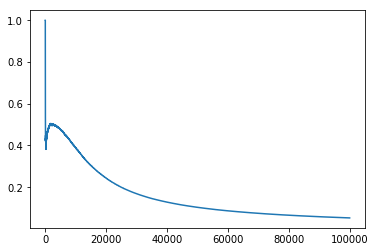

In [4066]:
accept_df = pd.Series(accepts).cumsum().reset_index()
(accept_df[0]/(accept_df['index']+1)).plot()


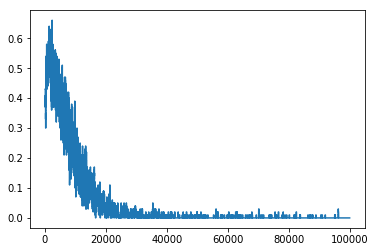

In [4067]:
accept_df = pd.Series(accepts).rolling(100).sum().reset_index()
(accept_df[0]/100).plot()


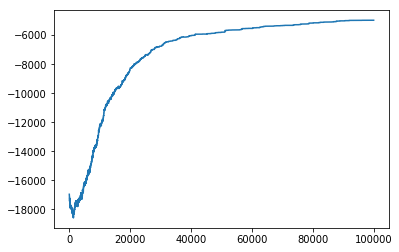

In [4068]:
plt.plot(probs)

In [4069]:
from matplotlib import animation, rc
from IPython.display import HTML

In [4070]:
calc_total_log_prob(affinity_tensor, samps[-1], kernel_size, stride)

-4974.238889382374

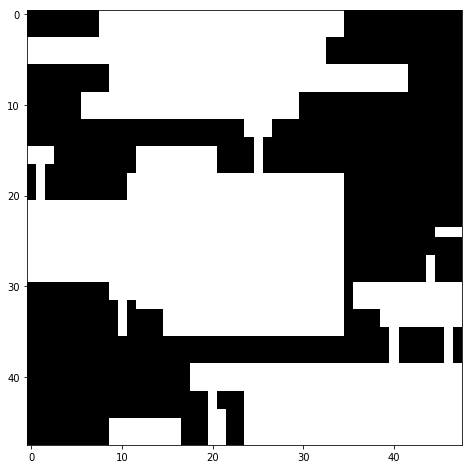

In [4071]:
plt.figure(figsize=(8,8))
plt.imshow(
   convert_blocks_to_img(samps[-1], block_size, blocks ),
    #samps[-1],
    cmap='gray')

/Users/milesturpin/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: Mean of empty slice.
  
/Users/milesturpin/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


TypeError: Invalid dimensions for image data

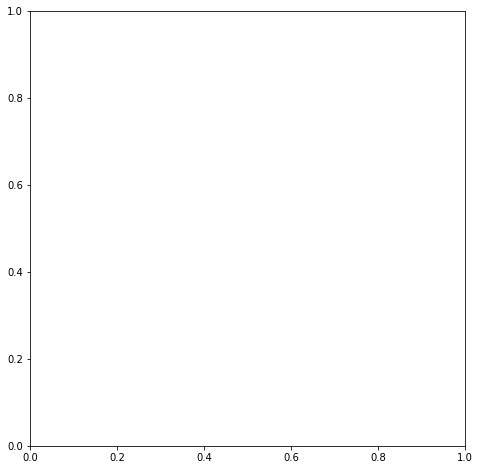

In [3933]:
plt.figure(figsize=(8,8))
plt.imshow(np.array(samps[9000:]).mean(axis=0), cmap='gray')

In [3274]:
import datetime

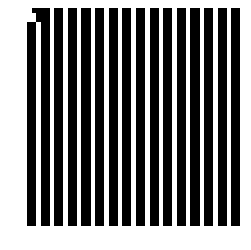

In [4072]:
fig, ax = plt.subplots(1,1, figsize=(4,4))

#im = ax.imshow(samps[0])
ax.axis('off')

num_frames=min(50, len(samps))
frame_idx = np.round(
    np.linspace(0, len(samps)-1, num_frames)).astype(int)

def init():
    im.set_array(samps[0])
    return im

def animate(i):
    #print(i)
    #ax.clear()
    ax.imshow(
        convert_blocks_to_img(samps[frame_idx[i]], block_size, blocks), 
        cmap='gray')
    #im.set_array(samps[i])

anim = animation.FuncAnimation(
    fig, animate, 
    frames=num_frames-1, 
    #init_func=init, 
    interval=75) 

directory = datetime.datetime.now().strftime("%m%d%y_%H%M%S")
anim.save(f'gifs/k{kernel_size}s{stride}ts{tot_steps}lb{lower_beta}ub{upper_beta}_{directory}.gif', writer='imagemagick')

/Users/milesturpin/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: Mean of empty slice.
/Users/milesturpin/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:154: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/Users/milesturpin/miniconda3/lib/python3.6/site-packages/matplotlib/image.py:395: UserWarning: Warning: converting a masked element to nan.
  dv = (np.float64(self.norm.vmax) -
/Users/milesturpin/miniconda3/lib/python3.6/site-packages/matplotlib/image.py:396: UserWarning: Warning: converting a masked element to nan.
  np.float64(self.norm.vmin))
/Users/milesturpin/miniconda3/lib/python3.6/site-packages/matplotlib/image.py:403: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
/Users/milesturpin/miniconda3/lib/python3.6/site-packages/matplotlib/image.py:408: UserWarning: Warning: converting a masked element to nan.
  a_max = np.float64(

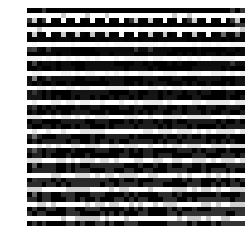

In [2270]:
fig, ax = plt.subplots(1,1, figsize=(4,4))

#im = ax.imshow(samps[0])
ax.axis('off')

samps_arr = np.array(samps)

num_frames=min(50, len(samps))
frame_idx = np.round(
    np.linspace(0, len(samps)-1, num_frames)).astype(int)

def init():
    im.set_array(samps[0])
    return im

def animate(i):
    #print(i)
    #ax.clear()
    ax.imshow(samps_arr[:frame_idx[i]].mean(axis=0), cmap='gray')
    #im.set_array(samps[i])

anim = animation.FuncAnimation(
    fig, animate, 
    frames=num_frames-1, 
    #init_func=init, 
    interval=75) 

directory = datetime.datetime.now().strftime("%m%d%y_%H%M%S")
anim.save(
    f'gifs/k{kernel_size}s{stride}ts{tot_steps}lb{lower_beta}ub{upper_beta}_{directory}_mean.gif', 
     writer='imagemagick')